# Data Preprocessing

**Reference**:  
- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
- https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9
- https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/
- Sarkar, D., Bali, R., & Sharma, T. (2018). Practical Machine Learning with Python. A Problem-Solvers Guide To Building Real-World Intelligent Systems, Berkely.
- https://contrib.scikit-learn.org/categorical-encoding/index.html
- https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02
- https://stats.idre.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/
- https://kiwidamien.github.io/james-stein-encoder.html
- https://chris-said.io/2017/05/03/empirical-bayes-for-multiple-sample-sizes/
- http://support.sas.com/documentation/cdl/en/prochp/66704/HTML/default/viewer.htm#prochp_hpbin_details02.htm
- https://catboost.ai/docs/concepts/algorithm-main-stages_cat-to-numberic.html
- https://docs.featuretools.com/en/stable/index.html
- https://heartbeat.fritz.ai/introduction-to-automated-feature-engineering-using-deep-feature-synthesis-dfs-3feb69a7c00b

## 1.1 Static Continuous Variables

### 1.1.1 Discretization

Discretizing the continuous variables might make the model more robust. For example, when predicting the purchasing behavior of customers, a customer making 30 previous purchases might have very similar behavior with a customer making 32 previous purchases. Sometimes the over-precision in the feature might be noise, and that's why in LightGBM, the model adopts a histogram algorithm to prevent over-fit.  

There are two ways to discretize the continuous variables.  

#### Binarization

Convert numeric features into binary responses

In [1]:
# load the sample data
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # we will take the first column as the example later

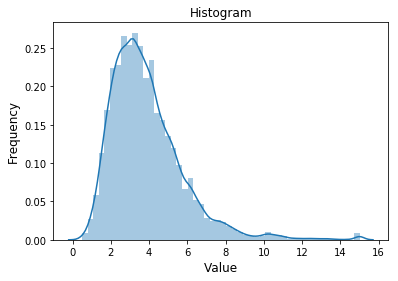

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.distplot(X[:,0], hist = True, kde=True)
ax.set_title('Histogram', fontsize=12)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12); # this feature has long-tail distribution

In [3]:
from sklearn.preprocessing import Binarizer

sample_columns = X[0:10,0] # select the top 10 samples
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])

model = Binarizer(threshold=6) # set 6 to be the threshold
# if value <= 6, then return 0 else return 1
result = model.fit_transform(sample_columns.reshape(-1,1)).reshape(-1)
# return array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

#### Binning

Map numeric features into bins

##### Uniform Binning

In [4]:
from sklearn.preprocessing import KBinsDiscretizer

# in order to mimic the operation in real-world, we shall fit the KBinsDiscretizer
# on the trainset and transform the testset
# we take the top ten samples in the first column as test set
# take the rest samples in the first column as train set

test_set = X[0:10,0]
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform') # set 5 bins
# return oridinal bin number, set all bins to have identical widths

model.fit(train_set.reshape(-1,1))
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1)  # transform train set
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # transform test set
# take transformed_test as demo: 
# transformed_test = array([2., 2., 2., 1., 1., 1., 1., 0., 0., 1.])
bin_edge = model.bin_edges_[0]
# return array([ 0.4999 ,  3.39994,  6.29998,  9.20002, 12.10006, 15.0001 ]), the bin edges

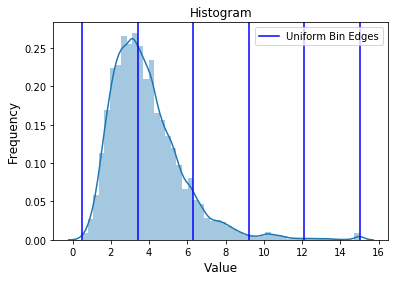

In [5]:
# visualiza the bin edges
fig, ax = plt.subplots()
sns.distplot(train_set, hist = True, kde=True)

for edge in bin_edge: # uniform bins
    line = plt.axvline(edge, color='b')
ax.legend([line], ['Uniform Bin Edges'], fontsize=10)
ax.set_title('Histogram', fontsize=12)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12); 

##### Quantile Binning

In [6]:
from sklearn.preprocessing import KBinsDiscretizer

# in order to mimic the operation in real-world, we shall fit the KBinsDiscretizer
# on the trainset and transform the testset
# we take the top ten samples in the first column as test set
# take the rest samples in the first column as train set

test_set = X[0:10,0]
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile') # set 3 bins
# return oridinal bin number, set all bins based on quantile

model.fit(train_set.reshape(-1,1))
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1)  # transform train set
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # transform test set
# take transformed_test as demo
# transformed_test = array([4., 4., 4., 4., 2., 3., 2., 1., 0., 2.])
bin_edge = model.bin_edges_[0]
# return array([ 0.4999 ,  2.3523 ,  3.1406 ,  3.9667 ,  5.10824, 15.0001 ]), the bin edges
# 2.3523 is the 20% quantile
# 3.1406 is the 40% quantile, etc..

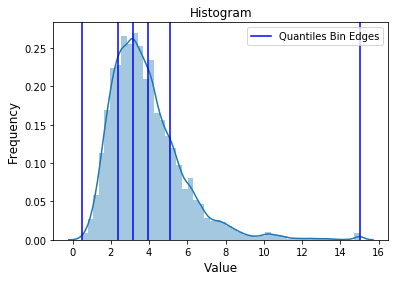

In [7]:
# visualiza the bin edges
fig, ax = plt.subplots()
sns.distplot(train_set, hist = True, kde=True)

for edge in bin_edge: # quantile based bins
    line = plt.axvline(edge, color='b')
ax.legend([line], ['Quantiles Bin Edges'], fontsize=10)
ax.set_title('Histogram', fontsize=12)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12); 

### Scaling

Different scales in features make it hard to compare features especially in linear models such as linear regression & logistic regression. In k-means clustering with Euclidean distance or KNN model, feature scaling is required or the distance measure becomes useless. For any algorithms using Gradient Descent, scaling will also speed up converging speed.

**Some commonly used models**
  
|Algorithm Name | Need Scaling |
|--|--|
| SVM, KNN, PCA, K-Means, Linear Regression, Logistic Regression, Linear Discriminant Analysis| $\checkmark$ |
| Naive Bayes, Tree-Based models | $\times$ |

* Skewness affect PCA models, so it might be better to use Power Transformation to remove skewness

#### Stardard Scaling (Z-score standardization)

Formula: ${X}' = \frac{X - \mu }{\sigma}$  
Where $\mu$ is the mean of X and $\sigma$ is the standard deviation  
This method is very sensitive to outliers because outliers affect both $\mu$ and $\sigma$

In [8]:
from sklearn.preprocessing import StandardScaler

# in order to mimic the operation in real-world, we shall fit the StandardScaler
# on the trainset and transform the testset
# we take the top ten samples in the first column as test set
# take the rest samples in the first column as train set

test_set = X[0:10,0]
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = StandardScaler()

model.fit(train_set.reshape(-1,1)) # fit on the train set and transform the test set
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1)  # transform train set
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # transform test set
# take transformed_test as demo:
# transformed_test =  array([ 2.34539745,  2.33286782,  1.78324852,  0.93339178, -0.0125957 ,
# 0.08774668, -0.11109548, -0.39490751, -0.94221041, -0.09419626])
# result is the same as ((X[0:10,0] - X[10:,0].mean())/X[10:,0].std())

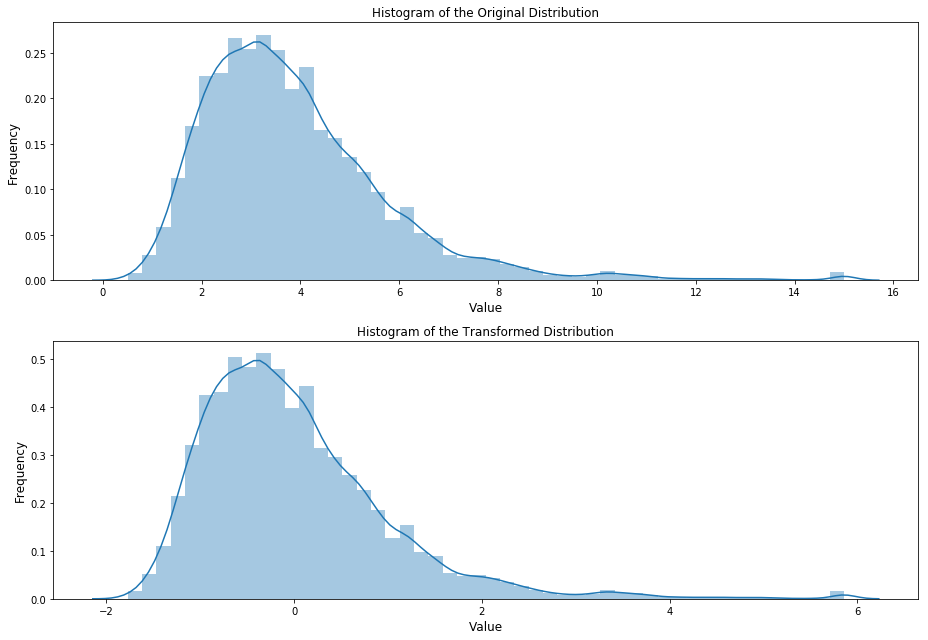

In [9]:
# visualize the distribution after the scaling
# fit and transform the entire first feature

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize = (13,9))
sns.distplot(X[:,0], hist = True, kde=True, ax=ax[0])
ax[0].set_title('Histogram of the Original Distribution', fontsize=12)
ax[0].set_xlabel('Value', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12); # this feature has long-tail distribution

model = StandardScaler()
model.fit(X[:,0].reshape(-1,1)) 
result = model.transform(X[:,0].reshape(-1,1)).reshape(-1)

# show the distribution of the entire feature
sns.distplot(result, hist = True, kde=True, ax=ax[1])
ax[1].set_title('Histogram of the Transformed Distribution', fontsize=12)
ax[1].set_xlabel('Value', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12); # the distribution is the same, but scales change
fig.tight_layout()

#### MinMaxScaler (Scale to range)

Suppose we want to rescale the feature to range (a,b)  
Formula: ${X}' = \frac{X - Min }{Max - Min} * (b - a) + a$  
Where $Min$ is the minimun of X and $Max$ is the maximun of X  
This method is also very sensitive to outliers because outliers affect both $Min$ and $Max$

In [10]:
from sklearn.preprocessing import MinMaxScaler

# in order to mimic the operation in real-world, we shall fit the MinMaxScaler
# on the trainset and transform the testset
# we take the top ten samples in the first column as test set
# take the rest samples in the first column as train set

test_set = X[0:10,0]
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = MinMaxScaler(feature_range=(0,1)) # set the range to be (0,1)

model.fit(train_set.reshape(-1,1)) # fit on the train set and transform the test set
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1)  # transform train set
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # transform test set
# take transformed_test as demo:
# transformed_test =  array([0.53966842, 0.53802706, 0.46602805, 0.35469856, 0.23077613,
# 0.24392077, 0.21787286, 0.18069406, 0.1089985 , 0.22008662])
# result is the same as (X[0:10,0] - X[10:,0].min())/(X[10:,0].max()-X[10:,0].min())

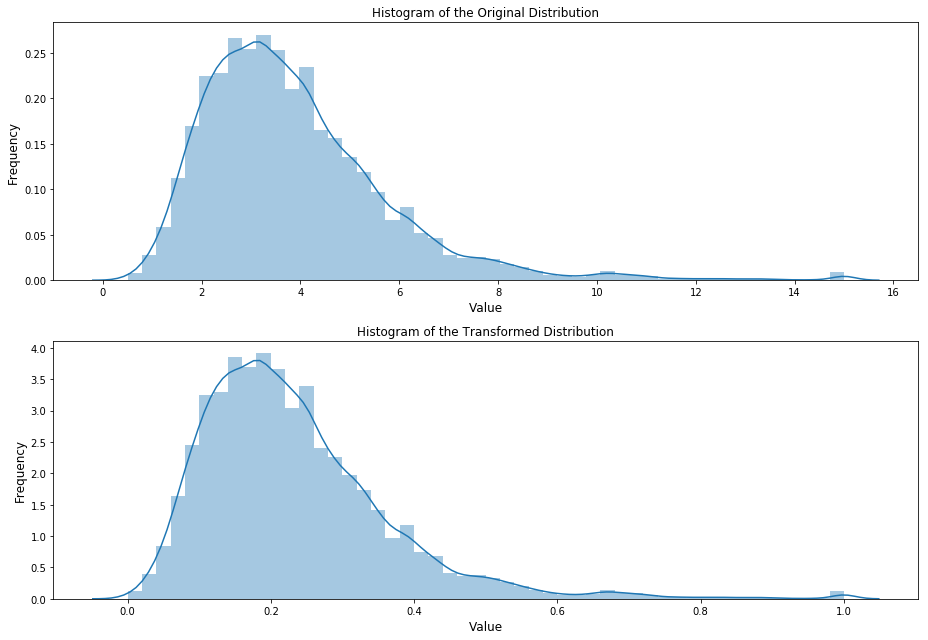

In [11]:
# visualize the distribution after the scaling
# fit and transform the entire first feature

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize = (13,9))
sns.distplot(X[:,0], hist = True, kde=True, ax=ax[0])
ax[0].set_title('Histogram of the Original Distribution', fontsize=12)
ax[0].set_xlabel('Value', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12); # this feature has long-tail distribution

model = MinMaxScaler(feature_range=(0,1))
model.fit(X[:,0].reshape(-1,1)) 
result = model.transform(X[:,0].reshape(-1,1)).reshape(-1)

# show the distribution of the entire feature
sns.distplot(result, hist = True, kde=True, ax=ax[1])
ax[1].set_title('Histogram of the Transformed Distribution', fontsize=12)
ax[1].set_xlabel('Value', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12); # the distribution is the same, but scales change
fig.tight_layout() # now the scale change to [0,1]

#### RobustScaler (Anti-outliers scaling)

Scale features using statistics (quantiles) that are robust to outliers  
Suppose we want to scale the feature to quantile range (a, b)  
Formula: ${X}' = \frac{X - Median}{X.quantile(b) - X.quantile(a)}$  
This method is more robust to outliers

In [12]:
import numpy as np
from sklearn.preprocessing import RobustScaler

# in order to mimic the operation in real-world, we shall fit the RobustScaler
# on the trainset and transform the testset
# we take the top ten samples in the first column as test set
# take the rest samples in the first column as train set

test_set = X[0:10,0]
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = RobustScaler(with_centering = True, with_scaling = True, 
                    quantile_range = (25.0, 75.0))
# with_centering = True => recenter the feature by set X' = X - X.median()
# with_scaling = True => rescale the feature by the quantile set by user
# set the quantile to the (25%, 75%)

model.fit(train_set.reshape(-1,1)) # fit on the train set and transform the test set
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1)  # transform train set
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # transform test set
# take transformed_test as demo:
# transformed_test = array([ 2.19755974,  2.18664281,  1.7077657 ,  0.96729508,  0.14306683,
# 0.23049401,  0.05724508, -0.19003715, -0.66689601,  0.07196918])
# result is the same as (X[0:10,0] - np.quantile(X[10:,0], 0.5))/(np.quantile(X[10:,0],0.75)-np.quantile(X[10:,0], 0.25))

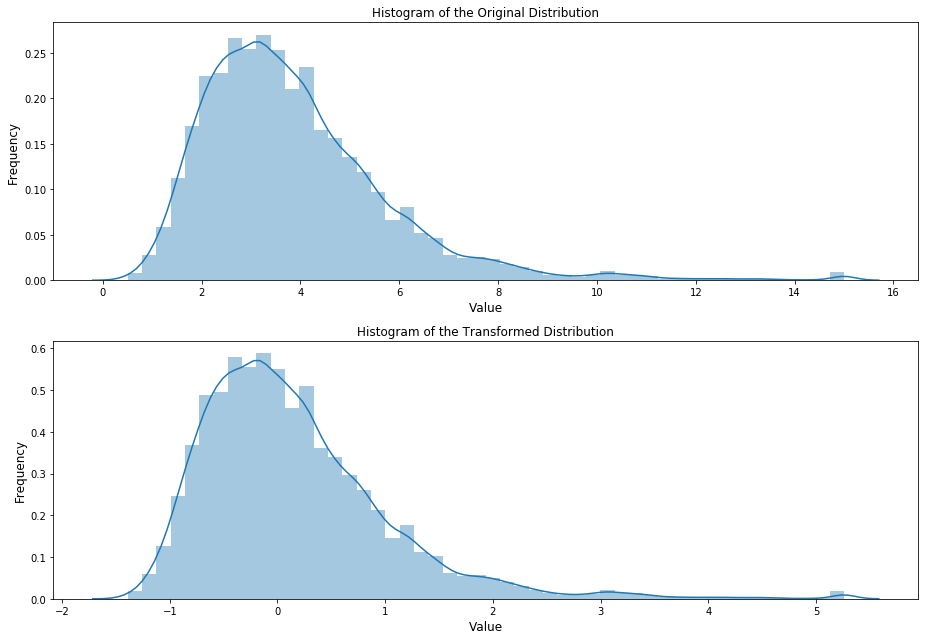

In [13]:
# visualize the distribution after the scaling
# fit and transform the entire first feature

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize = (13,9))
sns.distplot(X[:,0], hist = True, kde=True, ax=ax[0])
ax[0].set_title('Histogram of the Original Distribution', fontsize=12)
ax[0].set_xlabel('Value', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12); # this feature has long-tail distribution

model = RobustScaler(with_centering = True, with_scaling = True, 
                    quantile_range = (25.0, 75.0))
model.fit(X[:,0].reshape(-1,1)) 
result = model.transform(X[:,0].reshape(-1,1)).reshape(-1)

# show the distribution of the entire feature
sns.distplot(result, hist = True, kde=True, ax=ax[1])
ax[1].set_title('Histogram of the Transformed Distribution', fontsize=12)
ax[1].set_xlabel('Value', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12); # the distribution is the same, but scales change
fig.tight_layout() 

#### Power Transform (Non-linear transformation)

All the above scaling methods keep the original distribution. But normality is an important assumption for many statistical models. We can use Power Transform to convert the original distribution into a normal distribution. 

##### Box-Cox transformation

Box-Cox transformation only works for positive numbers and assumes the below distribution:  
$x_i(\lambda) = \left\{\begin{matrix}
 \frac{x_i^\lambda - 1}{\lambda}& if \lambda \neq 0\\ 
 log(\lambda)& if \lambda =  0
\end{matrix}\right.$  
All values of Œª are considered and the optimal value which stabilize variance and mimimize skewness will be selected through MLE. 

In [14]:
from sklearn.preprocessing import PowerTransformer

# in order to mimic the operation in real-world, we shall fit the PowerTransformer
# on the trainset and transform the testset
# we take the top ten samples in the first column as test set
# take the rest samples in the first column as train set

test_set = X[0:10,0]
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = PowerTransformer(method='box-cox', standardize=True)
# apply box-cox transformation

model.fit(train_set.reshape(-1,1)) # fit on the train set and transform the test set
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1)  # transform train set
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # transform test set
# take transformed_test as demo:
# transformed_test =  array([ 1.91669292,  1.91009687,  1.60235867,  1.0363095 ,  0.19831579,
# 0.30244247,  0.09143411, -0.24694006, -1.08558469,  0.11011933])

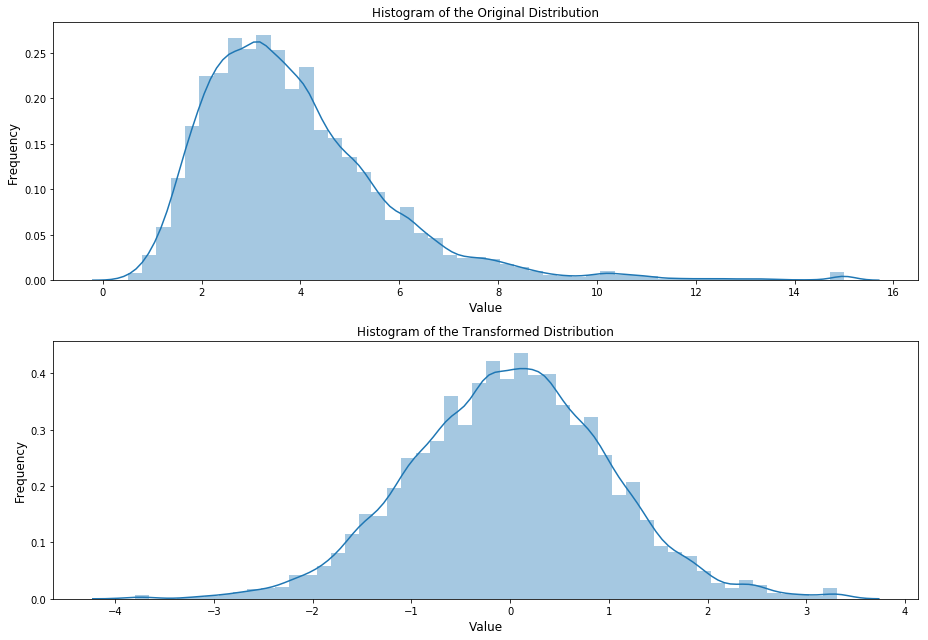

In [15]:
# visualize the distribution after the scaling
# fit and transform the entire first feature

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize = (13,9))
sns.distplot(X[:,0], hist = True, kde=True, ax=ax[0])
ax[0].set_title('Histogram of the Original Distribution', fontsize=12)
ax[0].set_xlabel('Value', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12); # this feature has long-tail distribution

model = PowerTransformer(method='box-cox', standardize=True)
model.fit(X[:,0].reshape(-1,1)) 
result = model.transform(X[:,0].reshape(-1,1)).reshape(-1)

# show the distribution of the entire feature
sns.distplot(result, hist = True, kde=True, ax=ax[1])
ax[1].set_title('Histogram of the Transformed Distribution', fontsize=12)
ax[1].set_xlabel('Value', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12); # the distribution now becomes normal
fig.tight_layout() 

##### Yeo-Johnson  transformation

Yeo-Johnson transformation works for both positive & negative numbers and assumes the below distribution:  
$x_i(\lambda) = \left\{\begin{matrix}
\frac{[(x_i + 1)^{\lambda} -1]}{\lambda} & if \, \, \lambda\neq 0, x_i \geq  0 \\ 
ln(x_i + 1) & if \, \, \lambda =  0, x_i \geq  0\\ 
-\frac{[(-x_i + 1)^{2- \lambda} -1]}{2-\lambda} & if \, \, \lambda\neq 2, x_i <  0 \\ 
-ln(-x_i + 1) & if \, \, \lambda =  2, x_i <  0\\ 
\end{matrix}\right.$  
All values of Œª are considered and the optimal value which stabilize variance and mimimize skewness will be selected through MLE. 

In [16]:
from sklearn.preprocessing import PowerTransformer

# in order to mimic the operation in real-world, we shall fit the PowerTransformer
# on the trainset and transform the testset
# we take the top ten samples in the first column as test set
# take the rest samples in the first column as train set

test_set = X[0:10,0]
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])
train_set = X[10:,0]

model = PowerTransformer(method='yeo-johnson', standardize=True)
# apply yeo-johnson transformation

model.fit(train_set.reshape(-1,1)) # fit on the train set and transform the test set
transformed_train = model.transform(train_set.reshape(-1,1)).reshape(-1)  # transform train set
transformed_test = model.transform(test_set.reshape(-1,1)).reshape(-1) # transform test set
# take transformed_test as demo:
# transformed_test = array([ 1.90367888,  1.89747091,  1.604735  ,  1.05166306,  0.20617221,
# 0.31245176,  0.09685566, -0.25011726, -1.10512438,  0.11598074])

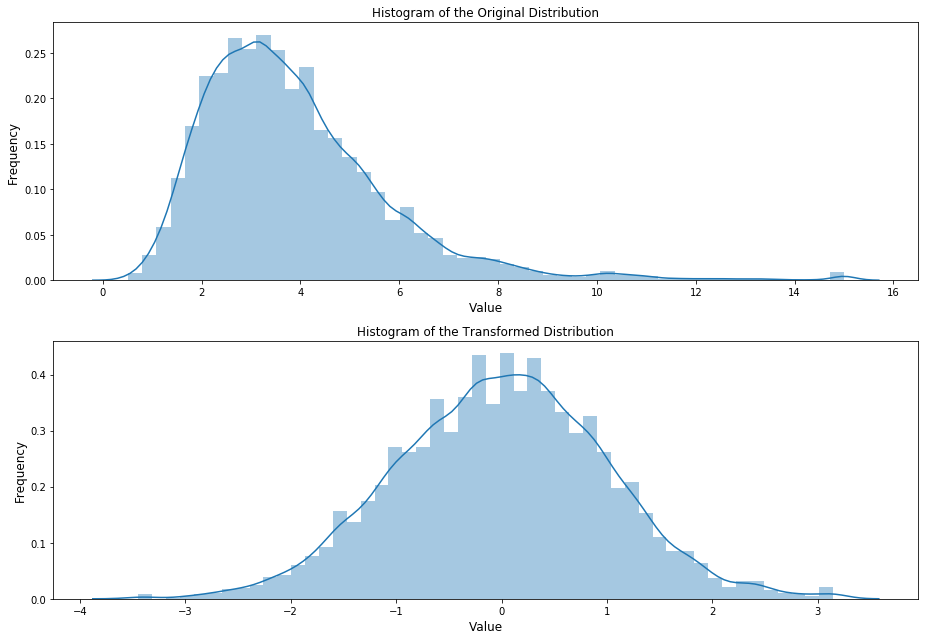

In [17]:
# visualize the distribution after the scaling
# fit and transform the entire first feature

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1, figsize = (13,9))
sns.distplot(X[:,0], hist = True, kde=True, ax=ax[0])
ax[0].set_title('Histogram of the Original Distribution', fontsize=12)
ax[0].set_xlabel('Value', fontsize=12)
ax[0].set_ylabel('Frequency', fontsize=12); # this feature has long-tail distribution

model = PowerTransformer(method='yeo-johnson', standardize=True)
model.fit(X[:,0].reshape(-1,1)) 
result = model.transform(X[:,0].reshape(-1,1)).reshape(-1)

# show the distribution of the entire feature
sns.distplot(result, hist = True, kde=True, ax=ax[1])
ax[1].set_title('Histogram of the Transformed Distribution', fontsize=12)
ax[1].set_xlabel('Value', fontsize=12)
ax[1].set_ylabel('Frequency', fontsize=12); # the distribution now becomes normal
fig.tight_layout() 

### Normalization

All the above scaling methods are column-wise operations. But normalization works on each row, it tries to "scale" each sample to have unit norm. Since normalization works on each row, it will distort the relationships between features so it is not commonly seen. But normalization method is quite useful in text classification and clustering contexts.

Suppose X[i][j] represent the value of feature j in sample i.  
Formula for L1 Norm: $X[i][j] = \frac{X[i][j]}{\sum_{j=1|X[i][j]|}}$  
Formula for L2 Norm: $X[i][j] = \frac{X[i][j]}{\sqrt{\sum_{j=1}X[i][j]^2}}$  

##### L1 Normalization

In [18]:
from sklearn.preprocessing import Normalizer

# Normalizer performs operation on each row independently
# So train set and test set are processed independently

###### for L1 Norm
sample_columns = X[0:2,0:3] # select the first two samples, and the first three features
# return array([[ 8.3252, 41., 6.98412698],
# [ 8.3014 , 21.,  6.23813708]])

model = Normalizer(norm='l1')
# use L1 Norm to normalize each samples

model.fit(sample_columns) 

result = model.transform(sample_columns) # test set are processed similarly
# return array([[0.14784762, 0.72812094, 0.12403144],
# [0.23358211, 0.59089121, 0.17552668]])
# result = sample_columns/np.sum(np.abs(sample_columns), axis=1).reshape(-1,1)

##### L2 Normalization

In [19]:
###### for L2 Norm
sample_columns = X[0:2,0:3] # select the first three features
# return array([[ 8.3252, 41., 6.98412698],
# [ 8.3014 , 21.,  6.23813708]])

model = Normalizer(norm='l2')
# use L2 Norm to normalize each samples

model.fit(sample_columns) 

result = model.transform(sample_columns) # test set are processed similarly
# return array([[0.19627663, 0.96662445, 0.16465922],
# [0.35435076, 0.89639892, 0.26627902]])
# result = sample_columns/np.sqrt(np.sum(sample_columns**2, axis=1)).reshape(-1,1)

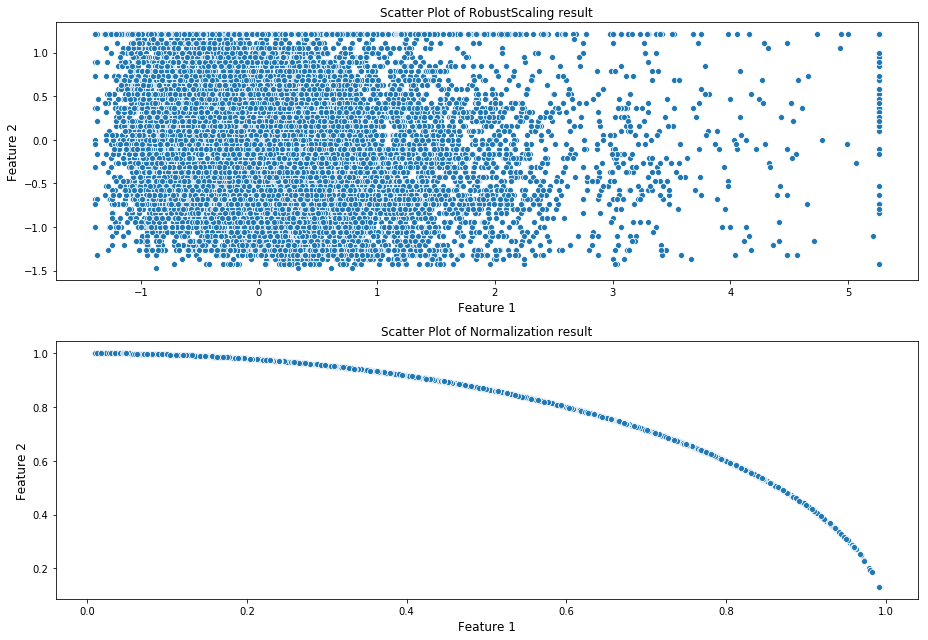

In [20]:
# visualize the difference in the distribuiton after Normalization
# compare it with the distribuiton after RobustScaling
# fit and transform the entire first & second feature

import seaborn as sns
import matplotlib.pyplot as plt

# RobustScaler
fig, ax = plt.subplots(2,1, figsize = (13,9))

model = RobustScaler(with_centering = True, with_scaling = True, 
                    quantile_range = (25.0, 75.0))
model.fit(X[:,0:2]) 
result = model.transform(X[:,0:2])

sns.scatterplot(x=result[:,0],y=result[:,1], ax=ax[0])
ax[0].set_title('Scatter Plot of RobustScaling result', fontsize=12)
ax[0].set_xlabel('Feature 1', fontsize=12)
ax[0].set_ylabel('Feature 2', fontsize=12)

model = Normalizer(norm='l2')

model.fit(X[:,0:2]) 
result = model.transform(X[:,0:2])

sns.scatterplot(x=result[:,0], y=result[:,1], ax=ax[1])
ax[1].set_title('Scatter Plot of Normalization result', fontsize=12)
ax[1].set_xlabel('Feature 1', fontsize=12)
ax[1].set_ylabel('Feature 2', fontsize=12)
fig.tight_layout()  # Normalization distort the original distribution

### Imputation of missing values

In real practice, the dataset might have missing values in them. However, such datasets with sparsity are incompatible with most of the scikit-learn models which assume that all features are numerical without missing values. So before applying scikit-learn models, we need to impute the missing values.

But some new models such as XGboost, LightGBM and Catboost implementing in other packages, provide support for the missing values in the dataset. So before applying these models, we are no longer required to fill the missing values in the dataset.

#### Univariate feature imputation

Suppose we have missing values in the ith column, then we will impute them with a constant, or using the statistics (average, median or mode) of the ith column.  

In [21]:
from sklearn.impute import SimpleImputer

test_set = X[0:10,0].copy() # no missing values
# return array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])

# manully create some missing values
test_set[3] = np.nan
test_set[6] = np.nan
# now test_set becomes 
# array([8.3252, 8.3014, 7.2574,    nan, 3.8462, 4.0368,    nan, 3.12 ,2.0804, 3.6912])

# create the train samples
# in real-world, we should fit the imputer on train set and tranform the test set.
train_set = X[10:,0].copy()
train_set[3] = np.nan
train_set[6] = np.nan

imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # use mean
# we can set the strategy to 'mean', 'median', 'most_frequent', 'constant'
imputer.fit(train_set.reshape(-1,1)) # fit on trainset
# transform train set and test set
transformed_train = imputer.transform(train_set.reshape(-1,1)).reshape(-1)
transformed_test = imputer.transform(test_set.reshape(-1,1)).reshape(-1)
# take transformed_test as demo:
# transformed_test = array([8.3252    , 8.3014    , 7.2574    , 3.87023658, 3.8462    ,
# 4.0368    , 3.87023658, 3.12      , 2.0804    , 3.6912    ])
# all missing values are imputed with 3.87023658
# 3.87023658 = np.nanmean(train_set) 
# which is the mean of the trainset ignoring missing values

#### Multivariate feature imputation

Multivariate feature imputation uses the information from the entire dataset to estimate and impute the missing values. In scikit-learn, it implements it in an iterated round-robin fashion.

"In each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion and then is repeated for max_iter imputation rounds. " - From scikit-learn official website.

##### Using Liner Models  (BayesianRidge as example)

In [22]:
from sklearn.experimental import enable_iterative_imputer # have to import this to enable
# IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

test_set = X[0:10,:].copy() # no missing values, select all features
# the first column is
# array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])

# manully create some missing values
test_set[3,0] = np.nan
test_set[6,0] = np.nan
test_set[3,1] = np.nan
# now the first feature becomes 
# array([8.3252, 8.3014, 7.2574,    nan, 3.8462, 4.0368,    nan, 3.12 ,2.0804, 3.6912])

# create the train samples
# in real-world, we should fit the imputer on train set and tranform the test set.
train_set = X[10:,:].copy()
train_set[3,0] = np.nan
train_set[6,0] = np.nan
train_set[3,1] = np.nan

impute_estimator = BayesianRidge()
imputer = IterativeImputer(max_iter = 10, 
                           random_state = 0, 
                           estimator = impute_estimator)

imputer.fit(train_set)
transformed_train = imputer.transform(train_set)
transformed_test = imputer.transform(test_set)

# take the first column as demo:
result = imputer.transform(test_set)[:,0] # revel how it works
# result  = array([8.3252    , 8.3014    , 7.2574    , 4.6237195 , 3.8462    ,
# 4.0368    , 4.00258149, 3.12      , 2.0804    , 3.6912    ])

##### Using Tree-Based Models  (ExtraTrees as an example)

In [23]:
from sklearn.experimental import enable_iterative_imputer # have to import this to enable
# IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

test_set = X[0:10,:].copy() # no missing values, select all features
# the first column is
# array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])

# manully create some missing values
test_set[3,0] = np.nan
test_set[6,0] = np.nan
test_set[3,1] = np.nan
# now the first feature becomes 
# array([8.3252, 8.3014, 7.2574,    nan, 3.8462, 4.0368,    nan, 3.12 ,2.0804, 3.6912])

# create the train samples
# in real-world, we should fit the imputer on train set and tranform the test set.
train_set = X[10:,:].copy()
train_set[3,0] = np.nan
train_set[6,0] = np.nan
train_set[3,1] = np.nan

impute_estimator = ExtraTreesRegressor(n_estimators=10, random_state=0)
imputer = IterativeImputer(max_iter = 10, 
                           random_state = 0, 
                           estimator = impute_estimator)

imputer.fit(train_set)
transformed_train = imputer.transform(train_set)
transformed_test = imputer.transform(test_set)

# take the first column as demo:
result = imputer.transform(test_set)[:,0] # revel how it works
# result =  array([8.3252 , 8.3014 , 7.2574 , 4.63813, 3.8462 , 4.0368 , 3.24721,
# 3.12   , 2.0804 , 3.6912 ])

##### Using K-Nearest Neighbors (KNN)

In [24]:
from sklearn.experimental import enable_iterative_imputer # have to import this to enable
# IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

test_set = X[0:10,:].copy() # no missing values, select all features
# the first column is
# array([8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.0368, 3.6591, 3.12, 2.0804, 3.6912])

# manully create some missing values
test_set[3,0] = np.nan
test_set[6,0] = np.nan
test_set[3,1] = np.nan
# now the first feature becomes 
# array([8.3252, 8.3014, 7.2574,    nan, 3.8462, 4.0368,    nan, 3.12 ,2.0804, 3.6912])

# create the train samples
# in real-world, we should fit the imputer on train set and tranform the test set.
train_set = X[10:,:].copy()
train_set[3,0] = np.nan
train_set[6,0] = np.nan
train_set[3,1] = np.nan

impute_estimator = KNeighborsRegressor(n_neighbors=10, 
                                       p = 1)  # set p=1 to use manhanttan distance
# use manhanttan distance to reduce effect from outliers

imputer = IterativeImputer(max_iter = 10, 
                           random_state = 0, 
                           estimator = impute_estimator)

imputer.fit(train_set)
transformed_train = imputer.transform(train_set)
transformed_test = imputer.transform(test_set)

# take the first column as demo:
result = imputer.transform(test_set)[:,0] # revel how it works
# result =  array([8.3252, 8.3014, 7.2574, 3.6978, 3.8462, 4.0368, 4.052 , 3.12  ,
# 2.0804, 3.6912])

#### Marking imputed values

Sometimes the information about which values had been missing can be informative.
So scikit-learn also provides the function to transform a dataset with missing values into corresponding binary matrix indicating the presence of missing values in the dataset.

In [25]:
from sklearn.impute import MissingIndicator

# illustrate this function on trainset only
# since the precess is independent in train set and test set
train_set = X[10:,:].copy() # select all features
train_set[3,0] = np.nan # manully create some missing values
train_set[6,0] = np.nan
train_set[3,1] = np.nan

indicator = MissingIndicator(missing_values=np.nan, features='all') 

# show the results on all the features
indicator_train = indicator.fit_transform(train_set) # result have the same shape with train_set
# contains only True & False, True corresponds with missing value

indicator_train[:,0].sum() # should return 2, the first column has two missing values
indicator_train[:,1].sum(); # should return 1, the second column has one missing value

### Feature Transformation

#### Polynomial Transformation

Sometimes we want to introduce nonlinear features into the model, therefore, increase complexity in the model. For simple linear models, this will increase the model complexity a lot. But for more complex models such as tree-based ML models, they already include nonlinear relationships in their non-parametric tree structures. Therefore, this feature transformation might not be that helpful for tree-based ML models.

For example, if we set the degree to 3 and also want to include the internaction term (below example).  
Then $(X_1, X_2) => (1, X_1, X_2, X_1^2, X_1X_2, X_2^2, X_1^3, X_1^2X_2, X_1X_2^2, X_2^3)$

In [26]:
from sklearn.preprocessing import PolynomialFeatures

# illustrate this function on one synthesized sample
train_set = np.array([2,3]).reshape(1,-1) # shape (1,2)
# return array([[2, 3]])

test_set = np.array([4,3]).reshape(1,-1)
# return array([[4, 3]])

poly = PolynomialFeatures(degree = 3, interaction_only = False)
# the highest degree is set to 3, and we want more than just intereaction terms

# take train set as an example: 
transformed_train = poly.fit_transform(train_set) # have shape (1, 10)
transformed_test = poly.fit_transform(test_set) # have shape (1, 10)

# take train set as an example: 
# transformed_train = array([[ 1.,  2.,  3.,  4.,  6.,  9.,  8., 12., 18., 27.]])
# match the above equation

#### Custom Transformation

In [27]:
from sklearn.preprocessing import FunctionTransformer

# illustrate this function on one synthesized sample
train_set = np.array([2,3]).reshape(1,-1) # shape (1,2)
# return array([[2, 3]])

test_set = np.array([4,3]).reshape(1,-1)
# return array([[4, 3]])

transformer = FunctionTransformer(func = np.log1p, validate=True)
# perform log transformation, X' = log(1 + x)
# func can be any numpy function such as np.exp

transformed_train = transformer.fit_transform(train_set) # has shape (1, 2)
transformed_test = transformer.fit_transform(test_set) # has shape (1, 2)

# take train set as an example: 
# transformed_train = return array([[1.09861229, 1.38629436]]), the same as np.log1p(train_set)

## Static Categorical Variables

In the real world, it is often that datasets include categorical features. But since models in scikit-learn can only handle numeric features, so we need to encode categorical features into continuous features. However, many new models such as lightGBM &Catboost implemented in other packages can directly support categorical features. Here we use category_encoders package since it covers more encoding methods.

### Ordinal Encoding

Ordinal Encoding transforms each categorical feature to one new feature of integers (1 to n_categories). 

In [28]:
import numpy as np
import pandas as pd
from category_encoders import OrdinalEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [29]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [30]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [31]:
encoder = OrdinalEncoder(cols=['Sex', 'Type'], 
                         handle_unknown = 'value', 
                         handle_missing = 'value').fit(train_set,train_y) # fit on trainset
# set handle_unknown to ‚Äòvalue‚Äò => mark unknown category value in the test set as -1
# set handle_missing to ‚Äòvalue‚Äò => mark missing value in the test set as -2
# other available options for handle_unknown/handle_missing: 
# 'error': report error; 'return_nan': mark unknown category / missing value as nan

encoded_train = encoder.transform(train_set) # transform the train set
encoded_test = encoder.transform(test_set) # transform the test set

encoded_test

# take the test set result as an example:
# In Oridnal Encoding:
  
# Feature Sex: 'male' => 1.0, 'female' => 2.0, unknown => -1., missing => -2.
# (it is also possible that testset have new labels)
# in our example, 'other' type in Sex feature is unknown
# since it never appears in train set
  
# Feature Type: 10 => 1.0, 20 => 2.0, 15 => 3.0, unknown => -1., missing => -2.

Sex  Type
0  2.0   2.0
1  1.0   2.0
2 -1.0   3.0
3  1.0   2.0
4  2.0  -2.0
5  1.0  -1.0

In [32]:
encoded_train.astype(float) # transformed train set

Sex  Type
0  1.0   1.0
1  2.0   2.0
2  1.0   1.0
3  2.0   2.0
4  2.0   3.0

### One-hot Encoding

One-hot Encoding in scikit-learn transforms categorical features with n_categories possible values into n_categories binary features, with one of them 1, and all others 0. In category_encoders, it will create one additional feature indicating missing or unknown values. Here we continue to use category_encoders.

In [33]:
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [34]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [35]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [36]:
encoder = OneHotEncoder(cols=['Sex', 'Type'], 
                        handle_unknown='indicator', 
                        handle_missing='indicator', 
                        use_cat_names=True).fit(train_set,train_y) #fit on train set
encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set) # transform test set
# set handle_unknown to ‚Äòindicator‚Äô => add a new column indicates unknown category value
# set handle_missing to ‚Äòindicator‚Äô => add a new column indicates missing value
# other handle_unknown/handle_missing optionÔºö
# ‚Äòerror‚ÄôÔºöreport error; ‚Äòreturn_nan‚ÄôÔºömark misssing/unknown as nan; 
# ‚Äòvalue‚ÄôÔºömark misssing/unknown as 0;

# take test set result as an example
encoded_test

# take the test set result as an example:
# In One-hot Encoding:
  
# feature Sex => 4 new columns: 'male' => [1 ,0 ,0, 0];
#                               'female' => [0 ,1 ,0, 0];
#                                unknown =>  [0 ,0 ,0, 1];
#                                missing => [0, 0, 1, 0];
    
# feature Type => 5 new columns: 10 => [1, 0, 0, 0, 0];
#                                20 => [0, 1, 0, 0, 0];, 
#                                15 => [0, 0, 1, 0, 0];
#                                unknown => [0, 0, 0, 0, 1];
#                                missing => [0, 0, 0, 1, 0];  

Sex_male  Sex_female  Sex_nan  Sex_-1  Type_10  Type_20  Type_15  Type_nan  \
0         0           1        0       0        0        1        0         0   
1         1           0        0       0        0        1        0         0   
2         0           0        0       1        0        0        1         0   
3         1           0        0       0        0        1        0         0   
4         0           1        0       0        0        0        0         1   
5         1           0        0       0        0        0        0         0   

   Type_-1  
0        0  
1        0  
2        0  
3        0  
4        0  
5        1

### Hashing Encoding

Hashing Encoding is based on the technique known as feature hashing. It applies a hash function to the features to map data of arbitrary number of features to fixed-size features. The hash function might cause collisions between features. The advantage of the hashing encoder is that it does not maintain a predefined dictionary of observed categories. Consequently, the encoder does not grow in size and accepts new values during data scoring by design.

In [37]:
import numpy as np
import pandas as pd
from category_encoders.hashing import HashingEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [38]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [39]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [40]:
encoder = HashingEncoder(cols=['Sex', 'Type'], 
                         n_components = 5).fit(train_set,train_y) 
encoded_train = encoder.transform(train_set) # transform the train set
encoded_test = encoder.transform(test_set) # transform the test set

# hash the dataset with two columns into 5 columns
# hashing encoding results has nothing to do with the content in train_set
# we can fit the hasher on any dataset as long as the column names matches.
# it is only deternmined by the hashing function

# normally hashing encoding should be apply to higher & sparser dimensional space 
# take test set result as example:
encoded_test

col_0  col_1  col_2  col_3  col_4
0      1      1      0      0      0
1      0      1      0      0      1
2      0      0      0      2      0
3      0      1      0      0      1
4      1      0      1      0      0
5      0      0      0      0      2

In [41]:
encoded_train # train set result

col_0  col_1  col_2  col_3  col_4
0      0      0      0      0      2
1      1      1      0      0      0
2      0      0      0      0      2
3      1      1      0      0      0
4      1      0      0      1      0

### Helmert Encoding

The Helmert Coding is commonly used in econometrics. After the Helmert Coding (Each value in the categorical feature corresponds with one row in the Helmert Matrix), the coefficient of the encoded columns in the linear model can reflect the mean of the dependent variable for a level compared with the mean of the dependent variable over all previous levels. The Helmert Coding implemented in the category_encoders package is referred to as Reverse Helmert Coding. For more reference, please check the [link](https://www.statsmodels.org/devel/contrasts.html).

In [42]:
import numpy as np
import pandas as pd
from category_encoders import HelmertEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [43]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [44]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [45]:
encoder = HelmertEncoder(cols=['Sex', 'Type'], 
                         handle_unknown='indicator', 
                         handle_missing='indicator').fit(train_set,train_y) # fit on trainset
encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set) # transform test set
# set handle_unknown to ‚Äòindicator‚Äô => add a new column indicates unknown category value
# set handle_missing to ‚Äòindicator‚Äô => add a new column indicates missing value
# other handle_unknown/handle_missing optionÔºö
# ‚Äòerror‚ÄôÔºöreport error; ‚Äòreturn_nan‚ÄôÔºömark misssing/unknown as nan; 
# ‚Äòvalue‚ÄôÔºömark misssing/unknown as 0;

# take test set result as an example
encoded_test

# take the test set result as an example:
# In Helmert Encoding: 
  
# feature Sex => 4 new columnsÔºàincluding interceptÔºâ: 'male' => [ 1. -1. -1. -1.];
#                                                     'female' => [ 1.  1. -1. -1.];
#                                                      unknown =>  [ 1.  0.  0.  3.];
#                                                       missing => [ 1.  0.  2. -1.];
    
# feature Type => 5 new columnsÔºàincluding interceptÔºâ: 10 => [ 1. -1. -1. -1. -1.];
#                                                      20 => [ 1.  1. -1. -1. -1.];
#                                                      15 => [ 1.  0.  2. -1. -1.];
#                                                      unknown =>  [ 1.  0.  0.  0.  4.];
#                                                      missing => [ 1.  0.  0.  3. -1.];  

intercept  Sex_0  Sex_1  Sex_2  Type_0  Type_1  Type_2  Type_3
0          1    1.0   -1.0   -1.0     1.0    -1.0    -1.0    -1.0
1          1   -1.0   -1.0   -1.0     1.0    -1.0    -1.0    -1.0
2          1    0.0    0.0    3.0     0.0     2.0    -1.0    -1.0
3          1   -1.0   -1.0   -1.0     1.0    -1.0    -1.0    -1.0
4          1    1.0   -1.0   -1.0     0.0     0.0     3.0    -1.0
5          1   -1.0   -1.0   -1.0     0.0     0.0     0.0     4.0

In [46]:
# can use the below code to calculate the Helmert Matrix for feature Type

from patsy.contrasts import Helmert
levels = [1,2,3,4,5] # 3 category value in trainset + 1 unknown + 1 missing
contrast = Helmert().code_with_intercept(levels)
print(contrast.matrix) # thge first column is intercept

[[ 1. -1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1.]
 [ 1.  0.  2. -1. -1.]
 [ 1.  0.  0.  3. -1.]
 [ 1.  0.  0.  0.  4.]]


In [47]:
encoded_train # train set result

intercept  Sex_0  Sex_1  Sex_2  Type_0  Type_1  Type_2  Type_3
0          1   -1.0   -1.0   -1.0    -1.0    -1.0    -1.0    -1.0
1          1    1.0   -1.0   -1.0     1.0    -1.0    -1.0    -1.0
2          1   -1.0   -1.0   -1.0    -1.0    -1.0    -1.0    -1.0
3          1    1.0   -1.0   -1.0     1.0    -1.0    -1.0    -1.0
4          1    1.0   -1.0   -1.0     0.0     2.0    -1.0    -1.0

### Sum (Deviation) Encoding

The Sum Coding is also commonly used in econometrics. After the Sum Coding, the coefficient of the encoded columns in the linear model can reflect the mean of the dependent variable for a given level compared with the overall mean of the dependent variable over all the levels. For more reference, please check the [link](https://www.statsmodels.org/devel/contrasts.html).

In [48]:
import numpy as np
import pandas as pd
from category_encoders.sum_coding import SumEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [49]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [50]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [51]:
encoder = SumEncoder(cols=['Sex', 'Type'], 
                     handle_unknown='indicator', 
                     handle_missing='indicator').fit(train_set,train_y) # fit on trainset
encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set)  # transform test set
# set handle_unknown to ‚Äòindicator‚Äô => add a new column indicates unknown category value
# set handle_missing to ‚Äòindicator‚Äô => add a new column indicates missing value
# other handle_unknown/handle_missing optionÔºö
# ‚Äòerror‚ÄôÔºöreport error; ‚Äòreturn_nan‚ÄôÔºömark misssing/unknown as nan; 
# ‚Äòvalue‚ÄôÔºömark misssing/unknown as 0;

# take test set result as an example
encoded_test

# take the test set result as an example:
# In Sum(Deviation) Encoding: 
  
# feature Sex => 4 new columnsÔºàincluding interceptÔºâ: 'male' => [ 1.  1.  0.  0.];
#                                                    'female' => [ 1.  0.  1.  0.];
#                                                     unknown =>  [ 1. -1. -1. -1.];
#                                                     missing => [ 1.  0.  0.  1.];
    
# feature Type => 5 new columnsÔºàincluding interceptÔºâ: 10 => [ 1.  1.  0.  0.  0.];
#                                                      20 => [ 1.  0.  1.  0.  0.];, 
#                                                      15 => [ 1.  0.  0.  1.  0.];
#                                                      unknown =>  [ 1. -1. -1. -1. -1.];
#                                                      missing => [ 1.  0.  0.  0.  1.];  

intercept  Sex_0  Sex_1  Sex_2  Type_0  Type_1  Type_2  Type_3
0          1    0.0    1.0    0.0     0.0     1.0     0.0     0.0
1          1    1.0    0.0    0.0     0.0     1.0     0.0     0.0
2          1   -1.0   -1.0   -1.0     0.0     0.0     1.0     0.0
3          1    1.0    0.0    0.0     0.0     1.0     0.0     0.0
4          1    0.0    1.0    0.0     0.0     0.0     0.0     1.0
5          1    1.0    0.0    0.0    -1.0    -1.0    -1.0    -1.0

In [52]:
# can use the below code to calculate theDeviation  Matrix for feature Type

from patsy.contrasts import Sum
levels = [1,2,3,4,5] # 3 category value in trainset + 1 unknown + 1 missing
contrast = Sum().code_with_intercept(levels)
print(contrast.matrix) # thge first column is intercept

[[ 1.  1.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.]
 [ 1.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  1.]
 [ 1. -1. -1. -1. -1.]]


In [53]:
encoded_train # train set result

intercept  Sex_0  Sex_1  Sex_2  Type_0  Type_1  Type_2  Type_3
0          1    1.0    0.0    0.0     1.0     0.0     0.0     0.0
1          1    0.0    1.0    0.0     0.0     1.0     0.0     0.0
2          1    1.0    0.0    0.0     1.0     0.0     0.0     0.0
3          1    0.0    1.0    0.0     0.0     1.0     0.0     0.0
4          1    0.0    1.0    0.0     0.0     0.0     1.0     0.0

### Target Encoding

Target encoding is a method to encode categorical variables with only one single column based on not only the feature values themselves but also the corresponding target.

For the case of categorical target: features are replaced with a blend of the posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.

For the case of continuous target: features are replaced with a blend of the expected value of the target given particular categorical value and the expected value of the target over all the training data.

This method relies heavily on the distribution of the target. But it significantly reduces the number of encoded features generated.

Formula:  
$smoove = \frac{1}{1+ exp(-\frac{n-min\_samples\_leaf}{smoothing})}$  
$X_k' = Prior\_Prob* (1 - smoove) + smoove * Condition\_Prob $  
$Condition\_Prob =\frac{n^{+}}{n} $
  
Where min_samples_leaf & smoothing are user defined parameters;  
min_samples_leaf: the minimum number of samples to take category average into account;  
smoothing: the smoothing effect to balance categorical average vs prior. Higher value means stronger regularization;  
$X_k'$ is the encoded value of value k in category feature X;  
Prior Prob: the prior probability/ expectation of the target variable;  
n: the number of samples that have value k in feature X;  
$n^{+}$: the number of samples that not only have value k in feature X but also have positive outcome;  
  
Reference: Micci-Barreca, D. (2001). A preprocessing scheme for high-cardinality categorical attributes in classification and prediction problems. ACM SIGKDD Explorations Newsletter, 3(1), 27-32.

In [54]:
import numpy as np
import pandas as pd
from category_encoders.target_encoder import TargetEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [55]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [56]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [57]:
encoder = TargetEncoder(cols=['Sex','Type'], 
                        handle_unknown='value',  
                        handle_missing='value').fit(train_set,train_y) # fit on trainset
# handle_unknown & handle_missingis set to 'value'
# they only accept ‚Äòerror‚Äô, ‚Äòreturn_nan‚Äô and ‚Äòvalue‚Äô, 
# both of them have default as ‚Äòvalue‚Äô
# which returns the target mean for unknown category or missing value

encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set)  # transform test set

encoded_test # only two columns are returned!

Sex      Type
0  0.341280  0.473106
1  0.473106  0.473106
2  0.400000  0.400000
3  0.473106  0.473106
4  0.341280  0.400000
5  0.473106  0.400000

In [58]:
# validate the result for male, which has encoded value 0.473106
prior = train_y.mean()
min_samples_leaf = 1.0 # default is 1.0
smothing = 1.0 # default is 1.0
n = 2 # 2 samples have male tag in train_set
n_positive = 1 # only one of them has positive outcome in train_set

ùë†ùëöùëúùëúùë£ùëí = 1 / (1 + np.exp(-(n - min_samples_leaf) / smothing))
male_encode = prior * (1-ùë†ùëöùëúùëúùë£ùëí) + ùë†ùëöùëúùëúùë£ùëí * n_positive/n
male_encode # return 0.4731058578630005

0.4731058578630005

In [59]:
encoded_train # train set result

Sex      Type
0  0.473106  0.473106
1  0.341280  0.473106
2  0.473106  0.473106
3  0.341280  0.473106
4  0.341280  0.400000

### M-estimate Encoding

M-estimate Encoding is a simplified version of the target encoder, which goes under names like m-probability estimate or additive smoothing with known incidence rates. In comparison to the target encoder, m-probability estimate has only one tunable parameter (m), while the target encoder has two tunable parameters (min_samples_leaf and smoothing).

Formula:  
$X_k' = \frac{n^{+} + prior * m}{y^{+} + m}$  

Where m is a user defined parameter;  
m: higher value of m results in stronger shrinking. M is non-negative.  
$X_k'$ is the encoded value of value k in category feature X;  
Prior: the prior probability/ expectation of the target variable;  
$n^{+}$: the number of sample that not only have value k in feature X but also have positive outcome;  
$y^{+}$: the number of sample that have positive outcome;  
  
Reference: Micci-Barreca, D. (2001). A preprocessing scheme for high-cardinality categorical attributes in classification and prediction problems. ACM SIGKDD Explorations Newsletter, 3(1), 27-32.

In [60]:
import numpy as np
import pandas as pd
from category_encoders.m_estimate import MEstimateEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [61]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [62]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [63]:
encoder = MEstimateEncoder(cols=['Sex','Type'], 
                           handle_unknown='value',  
                           handle_missing='value').fit(train_set,train_y) # fit on trainset
# handle_unknown & handle_missingis set to 'value'
# they only accept ‚Äòerror‚Äô, ‚Äòreturn_nan‚Äô and ‚Äòvalue‚Äô, 
# both of them have default as ‚Äòvalue‚Äô
# which returns the target mean for unknown category or missing value

encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set)  # transform test set

encoded_test # only two columns are returned!

Sex      Type
0  0.350000  0.466667
1  0.466667  0.466667
2  0.400000  0.200000
3  0.466667  0.466667
4  0.350000  0.400000
5  0.466667  0.400000

In [64]:
# validate the result for male, which has encoded value 0.466667

y_positive = 2 # 2 samples have positive outcome in train_y
n_positive = 1 # 2 samples have male tag in train_set, only one has positive outcome in train_set
prior = train_y.mean()
m = 1.0 # default value
male_encode = (n_positive + prior * m)/(y_positive + m)
male_encode # return 0.4666666666666666

0.4666666666666666

In [65]:
encoded_train # train set result

Sex      Type
0  0.466667  0.466667
1  0.350000  0.466667
2  0.466667  0.466667
3  0.350000  0.466667
4  0.350000  0.200000

### James-Stein Encoder

James-Stein Encoder is also an encoding method based on target encoding. James-Stein Encoder tries to balance the conditional probability for the observed feature value i and the prior probability through parameter B. This is quite similar to the target encoder, but James-Stein Encoder balances two probabilities by the variance ratio instead of the sample size. ¬†

It uses several methods such as independent method, pooled method, etc. to estimate the parameter B. For more information, please refer to [the official website of category_encoders](http://contrib.scikit-learn.org/categorical-encoding/jamesstein.html). 
James-Stein Encoder is defined only for normal distributions. To meet the required assumption, we can either convert binary targets with a log-odds ratio as it was done in WoE Encoder (which is used by default because it is simple) or use beta distribution.¬†¬†

The formula for independent method:  
$X_k' = (1 - B) * Condition\_Prob + B * prior $  
$B = \frac{Var(y^{k})}{Var(y^{k}) + Var(y)}$  
$Condition\_Prob =\frac{n^{+}}{n} $
  
Where,
$X_k'$ is the encoded value of value k in category feature X;  
Prior: the prior probability/ expectation of the target variable;  
$n^{+}$: the number of sample that not only have value k in feature X but also have positive outcome;  
$n$: the number of sample that have value k;  
$Var(y^{k})$: the variance of the population (that have value k in feature X)' outcome mean;  
$Var(y)$: the variance of the population outcome;  
Both $Var(y^{k})$ & $Var(y)$ should be estimated through sample statistics. The intuition behind B is that: if Condition_Prob, the estimate of mean(y_k) is unreliable (y_k has high variance), we should put more weight on the prior, which is mean(y). 

In [66]:
import numpy as np
import pandas as pd
from category_encoders.james_stein import JamesSteinEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [67]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [68]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [69]:
encoder = JamesSteinEncoder(cols=['Sex','Type'], 
                           handle_unknown='value', 
                           model='independent',  
                           handle_missing='value').fit(train_set,train_y) # fit on trainset
# handle_unknown & handle_missingis set to 'value'
# they only accept ‚Äòerror‚Äô, ‚Äòreturn_nan‚Äô and ‚Äòvalue‚Äô, 
# both of them have default as ‚Äòvalue‚Äô
# which returns the target mean for unknown category or missing value

encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set)  # transform test set

encoded_test # only two columns are returned!

# since in the category_encoders, it modifies slightly the equation above, so we will not
# validate the results.

Sex  Type
0  0.333333   0.5
1  0.500000   0.5
2  0.400000   0.0
3  0.500000   0.5
4  0.333333   0.4
5  0.500000   0.4

In [70]:
encoded_train # train set result

Sex  Type
0  0.500000   0.5
1  0.333333   0.5
2  0.500000   0.5
3  0.333333   0.5
4  0.333333   0.0

### Weight of Evidence Encoder

The weight of evidence encoder also encodes the categorical variable based on their relationship with the target variable. 

Formula:  
$WoE = X_k' = ln(\frac{distribution\_of\_positive}{distribution\_of\_negative})$  
$distribution\_of\_positive = \frac{n^{+}}{y^{+}}$  
$distribution\_of\_negative = \frac{n^{-}}{y^{-}}$  
  
Above is the original definition of WoE, but in category_encoders, it also adds regulization to prevent overfitting. So the new $distribution\_of\_positive$, $distribution\_of\_negative$ are as below:  

$distribution\_of\_positive = \frac{n^{+} + regularization }{y^{+} + 2 * regularization }$  
$distribution\_of\_negative = \frac{n^{-} + regularization }{y^{-} + 2 * regularization }$ 

In [71]:
import numpy as np
import pandas as pd
from category_encoders.woe import WOEEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [72]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [73]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [74]:
encoder = WOEEncoder(cols=['Sex','Type'], 
                     handle_unknown='value',  
                     handle_missing='value').fit(train_set,train_y) # fit on trainset

# handle_unknown & handle_missingis set to 'value'
# they only accept ‚Äòerror‚Äô, ‚Äòreturn_nan‚Äô and ‚Äòvalue‚Äô, 
# both of them have default as ‚Äòvalue‚Äô
# which returns the target mean for unknown category or missing value

encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set)  # transform test set

encoded_test # only two columns are returned!

Sex      Type
0 -0.182322  0.223144
1  0.223144  0.223144
2  0.000000  0.000000
3  0.223144  0.223144
4 -0.182322  0.000000
5  0.223144  0.000000

In [75]:
# validate the result for male, which has encoded value 0.223144

y = 5 # 5 samples in the train_set
y_positive = 2 # 2 samples have positive outcome in train_y

n = 2 # 2 samples have male tag in train_set
n_positive = 1 # only one has positive outcome in train_set

regularization = 1.0 # default value

dis_postive = (n_positive + regularization) / (y_positive + 2 * regularization)
dis_negative = (n - n_positive + regularization) / (y - y_positive + 2 * regularization)
male_encode = np.log(dis_postive / dis_negative)
male_encode # return  0.22314355131420976

0.22314355131420976

In [76]:
encoded_train # train set result

Sex      Type
0  0.223144  0.223144
1 -0.182322  0.223144
2  0.223144  0.223144
3 -0.182322  0.223144
4 -0.182322  0.000000

### Leave One Out Encoder

Leave One Out Encoder simply encodes each group(a unique value group in categorical feature) by the group mean. But it takes over-fitting into consideration and encodes each sample in the train set by the group mean excluding the sample itself. So in the trainset, each sample that has the same group value may be encoded in different values.

It encodes test set in a different way, each sample in the test set is encoded by the group mean in the train set without any exclusion.

Formula:  
Train set: $X_i^k = \frac{\sum_{j\neq i} (y_j * (x_j == k))}{\sum_{j\neq i} ( x_j == k)}$  
Test set: $X_i^k = \frac{\sum_{j} (y_j * (x_j == k))}{\sum_{j} ( x_j == k)}$  
($x_j == k$) will return 1 if sample j have tag K in categorical feature X and return 0 if not  
$X_i^k$ is the encoded value of sample i if it has value k in category feature X; 

In [77]:
import numpy as np
import pandas as pd
from category_encoders.leave_one_out import LeaveOneOutEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [78]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [79]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [80]:
encoder = LeaveOneOutEncoder(cols=['Sex','Type'], 
                             handle_unknown='value',  
                             handle_missing='value').fit(train_set,train_y) # fit on trainset

# handle_unknown & handle_missingis set to 'value'
# they only accept ‚Äòerror‚Äô, ‚Äòreturn_nan‚Äô and ‚Äòvalue‚Äô, 
# both of them have default as ‚Äòvalue‚Äô
# which returns the target mean for unknown category or missing value

encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set)  # transform test set

encoded_test # only two columns are returned!

Sex  Type
0  0.333333   0.5
1  0.500000   0.5
2  0.400000   0.4
3  0.500000   0.5
4  0.333333   0.4
5  0.500000   0.4

In [81]:
# encoded result for train_set
LeaveOneOutEncoder(cols=['Sex','Type'],
                   handle_unknown='value',  
                   handle_missing='value').fit_transform(train_set,train_y)
# for the first sample, it has male tag, when excluding this sample, the sample for male
# group becomes 1.0 (only one sample has male tage, and it has positive outcome)
# But for third samples, although it also has male tag, it is encoded with 0.0

Sex  Type
0  1.0   1.0
1  0.0   0.0
2  0.0   0.0
3  0.5   1.0
4  0.5   0.4

### Catboost Encoder

CatBoost is a Gradient Boosting model that has excellent results especially for the dataset contains a large number of categorical features. The model proposes a new encoding system based on Leave One Out Encoder for categorical features. The training data have to be randomly permutated before using Catboost Encoder because, in Catboost, the encoded value is based on an idea of ‚Äútime‚Äù, which is the order of observations in the dataset.

Formula:  
Train set: $\frac{\sum_{j < i} (y_j * (x_j == k)) + a * Prior}{\sum_{j<i} (x_j == k) + a}$  
Test set: $X_i^k = \frac{\sum_{j} (y_j * (x_j == k)) + a * Prior}{\sum_{j} ( x_j == k) + a}$  
($x_j == k$) will return 1 if sample j have tag K in categorical feature X and return 0 if not  
$X_i^k$ is the encoded value of sample i if it has value k in category feature X;  
Prior is the prior probability/ expectation of the target variable;  
a is the regularization term.

In [82]:
import numpy as np
import pandas as pd
from category_encoders.cat_boost import CatBoostEncoder
# category_encoders package directly support dataframe

# create some train set
train_set = pd.DataFrame(np.array([['male',10],['female', 20], ['male',10], 
                       ['female',20],['female',15]]),
             columns = ['Sex','Type'])
train_y = np.array([False, True, True, False, False])

# create some test set, include unknown category & missing value
test_set = pd.DataFrame(np.array([['female',20],['male', 20], ['others',15], 
                       ['male',20],['female', 40], ['male', 25]]),
             columns = ['Sex','Type'])
test_set.loc[4,'Type'] = np.nan

In [83]:
train_set # original train set

Sex Type
0    male   10
1  female   20
2    male   10
3  female   20
4  female   15

In [84]:
test_set # original test set

Sex Type
0  female   20
1    male   20
2  others   15
3    male   20
4  female  NaN
5    male   25

In [85]:
# in fact before fitting the trainset,we should shuffle the dataset
# but since our dataset is generated at random, we don't need to shuffle.

encoder = CatBoostEncoder(cols=['Sex','Type'], 
                          handle_unknown='value',  
                          handle_missing='value').fit(train_set,train_y) # fit on trainset

# handle_unknown & handle_missingis set to 'value'
# they only accept ‚Äòerror‚Äô, ‚Äòreturn_nan‚Äô and ‚Äòvalue‚Äô, 
# both of them have default as ‚Äòvalue‚Äô
# which returns the target mean for unknown category or missing value

encoded_train = encoder.transform(train_set) # transform train set
encoded_test = encoder.transform(test_set)  # transform test set

encoded_test # only two columns are returned!

Sex      Type
0  0.350000  0.466667
1  0.466667  0.466667
2  0.400000  0.400000
3  0.466667  0.466667
4  0.350000  0.400000
5  0.466667  0.400000

In [86]:
# validate the result for male in the test set, which has encoded value 0.466667

Prior = train_y.mean()
n = 2 # there are two samples in the train_set that has male tag
n_positive = 1 # only one of them has positive outcome
a = 1 # default value

encoded_male = (n_positive + a * prior) / (n + a)
encoded_male # return 0.4666666666666666

0.4666666666666666

In [87]:
# encoded result for train_set
CatBoostEncoder(cols=['Sex','Type'],
                handle_unknown='value',  
                handle_missing='value').fit_transform(train_set,train_y)

Sex  Type
0  0.400000   0.4
1  0.400000   0.4
2  0.200000   0.2
3  0.700000   0.7
4  0.466667   0.4

In [88]:
# validate the above result for the third sample in the train set that have male tag
Prior = train_y.mean()
n = 1 # there are one samples in the train_set that has male tag and before the third sample
n_positive = 0 #None of them has positive outcome
a = 1 # default value

encoded_male = (n_positive + a * Prior) / (n + a)
encoded_male # return 0.2

0.2

## Time Series Variables

Sometime the dataset might be time-series. In this case, we can utilize the Featuretools package in python to perform automated feature engineering. Specifically, we can "accumulate" information across time.

In [89]:
# Synthesize some sample data to record each users' behaviors after each login activities,
# such as users' stay time, products purchased, etc.

import numpy as np
import pandas as pd
import featuretools as ft
import datetime

raw_dataset = np.array([['001',100, 'Apple', '2020/01/01', 'male', 35, 1],
                        ['002',20, np.nan, '2020/01/01', 'female', 30, 0],
                        ['003',50, 'Orange','2020/01/01', 'male', 20, 1],
                        ['001', 13, np.nan, '2020/01/03', 'male', 35, 0],
                        ['002', 30, 'Apple', '2020/01/03','female', 30, 1], 
                        ['001', 90, 'Orange', '2020/01/06', 'male', 35, 1], 
                        ['003', 5, 'Orange', '2020/01/07', 'male', 20, 1]])

dataset = pd.DataFrame(raw_dataset, columns = ['Customer ID', 'Seconds Stay', 'Item Purchase',
                                               'Time', 'Sex', 'Age', 'Target'])
dataset['Seconds Stay'] = dataset['Seconds Stay'].astype(int)
dataset['Target'] = dataset['Target'].astype(int)
dataset['Age'] = dataset['Age'].astype(int)
dataset['Time'] = pd.to_datetime(dataset['Time'])
dataset['Item Purchase'] = dataset['Item Purchase'].replace("nan", np.nan)

dataset # in Item Purchase variable, NaN value means that the client didn't purchase anything

Customer ID  Seconds Stay Item Purchase       Time     Sex  Age  Target
0         001           100         Apple 2020-01-01    male   35       1
1         002            20           NaN 2020-01-01  female   30       0
2         003            50        Orange 2020-01-01    male   20       1
3         001            13           NaN 2020-01-03    male   35       0
4         002            30         Apple 2020-01-03  female   30       1
5         001            90        Orange 2020-01-06    male   35       1
6         003             5        Orange 2020-01-07    male   20       1

### Time Series Categorical Features

One possible data science question might be: how to predict customer purchase behavior in the above synthetic data. Specifically, we may want to predict whether customer 002 will buy something when he login on 2020-01-08.

In the above dataset, the only categorical variable is Item Purchase. Based on this categorical variable, we can synthesize some new categorical/numeric variables: how many purchase has he made before each login activities, how many unique items have he purchased  before each login activities, what is his favorite product before each login activities.  

These variables can be easily generated through the Featuretools package.

Some useful feature transformation offered in featuretools:  
- COUNT: Determines the total number of values, excluding NaN before a give time.
- Mode: Determines the most commonly repeated value before a give time.
- NumUnique: Determines the number of distinct values, ignoring NaN values before a give time.
- Entropy: Calculates the entropy for a categorical variable before a give time.
- First: Determines the first value in a list before a give time.
- Last: Determines the last value in a list before a give time.  
  
There are far more feature transformation available in featuretools, please reference [official website](https://docs.featuretools.com/en/stable/api_reference.html#aggregation-primitives).

### Time Series Continuous Features

Assume we have the same data science question as above: we want to predict whether the customer 002 will buy when he login on 2020-01-08.  

The only continuous variable in the above data is Seconds Stay, which is how long each customer stays after each login. Based on this continuous variable, we can perform feature engineering and synthesize the following new variables: his average stay time before each login, the standard deviation of his stay time before each login, the moving average of his stay time before each login, etc.

These variables can also be easily implemented through the Featuretools package.

Some useful feature transformation offered in featuretools:  
- COUNT: Determines the total number of values, excluding NaN before a give time.
- First: Determines the first value in a list before a give time.
- Last: Determines the last value in a list before a give time.
- Mean: Computes the average for a list of values before a give time.
- Sum: Calculates the total addition, ignoring NaN before a give time.
- Min: Calculates the smallest value, ignoring NaN values before a give time.
- Max: Calculates the highest value, ignoring NaN values before a give time.
- Std: Computes the dispersion relative to the mean value, ignoring NaN before a give time.
- Median: Determines the middlemost number in a list of values before a give time.
- Trend: Calculates the trend of a variable over time before a give time.  
  
There are far more feature transformation available in featuretools, please reference [official website](https://docs.featuretools.com/en/stable/api_reference.html#aggregation-primitives).

### Implementation

In [90]:
# original dataset
dataset

Customer ID  Seconds Stay Item Purchase       Time     Sex  Age  Target
0         001           100         Apple 2020-01-01    male   35       1
1         002            20           NaN 2020-01-01  female   30       0
2         003            50        Orange 2020-01-01    male   20       1
3         001            13           NaN 2020-01-03    male   35       0
4         002            30         Apple 2020-01-03  female   30       1
5         001            90        Orange 2020-01-06    male   35       1
6         003             5        Orange 2020-01-07    male   20       1

#### Create EntitySet

In [91]:
# firstly, we need to create EntitySet which is a collection of entities 
# and the relationships between them
# They are useful for preparing raw, structured datasets for auto feature engineering.

es = ft.EntitySet(id="customer_data") # create empty EntitySet

# one entity should be each customers
# the dataset contains information at customer level such as Sex, Age
df_customer = dataset[['Customer ID', 'Sex', 'Age']].drop_duplicates()
df_customer

Customer ID     Sex  Age
0         001    male   35
1         002  female   30
2         003    male   20

In [92]:
# now we will add this entity into the EntitySet
es = es.entity_from_dataframe(entity_id="Customer",
                              dataframe=df_customer,
                              index= 'Customer ID') # the Customer ID is the variable to index the entity

es['Customer']

Entity: Customer
  Variables:
    Customer ID (dtype: index)
    Sex (dtype: categorical)
    Age (dtype: numeric)
  Shape:
    (Rows: 3, Columns: 3)

In [93]:
# the second entity should be each transaction
# we also have information at transaction level, such as Item Purchase, Seconds Stay
es = es.entity_from_dataframe(entity_id="Transaction",
                              dataframe=dataset[["Customer ID","Seconds Stay", 
                                                 "Item Purchase", 
                                                 "Time","Target"]].reset_index(),
                              index="index", # the variable used to index the entity
                              time_index="Time", # the time index
                              variable_types={"Item Purchase": ft.variable_types.Categorical, 
                                              "Seconds Stay": ft.variable_types.Numeric,
                                              "Target": ft.variable_types.Numeric})
es['Transaction']

Entity: Transaction
  Variables:
    index (dtype: index)
    Customer ID (dtype: categorical)
    Time (dtype: datetime_time_index)
    Item Purchase (dtype: categorical)
    Seconds Stay (dtype: numeric)
    Target (dtype: numeric)
  Shape:
    (Rows: 7, Columns: 6)

In [94]:
# now we will add a relationship
relationship = ft.Relationship(es["Customer"]["Customer ID"],
                               es["Transaction"]["Customer ID"])
# Each customer has multiple transactions associated with it, so it is called it the 
# parent entity, while the transactions entity is known as the child entity

es = es.add_relationship(relationship)
es

Entityset: customer_data
  Entities:
    Customer [Rows: 3, Columns: 3]
    Transaction [Rows: 7, Columns: 6]
  Relationships:
    Transaction.Customer ID -> Customer.Customer ID

#### Set up cut-time

More information can be viewed at Featuretools official website: https://docs.featuretools.com/en/stable/automated_feature_engineering/handling_time.html

In [95]:
# Create cut time
# Oftentimes, in time series data sets
# they may come from different points in time
# if we cannot handle time information well
# we may leak future inforamtion into the model

# So we need to set Cut-time
# it helps Featuretool to realize that it needs to consider information leakage problem
# we can pass a dataframe to Featuretools to specify the corresponding cut time for each row
# it specifies the last point in time that a row‚Äôs data can be used for feature generation
# that is, for each row of data, 
# when performing corresponding feature engineering, 
# we will only consider the information before the cut time point of this row

ct = dataset[['Customer ID','Time']].copy() # the cut-off dataframe
ct

Customer ID       Time
0         001 2020-01-01
1         002 2020-01-01
2         003 2020-01-01
3         001 2020-01-03
4         002 2020-01-03
5         001 2020-01-06
6         003 2020-01-07

In [96]:
# but in our case, we want the cut-off time for each row to be slightly early in our case
# because we don't have the current row information to predict the purchase at that time
# for example, we won't know which product a custimer bought until he finished the purchase

ct['Time'] = ct['Time'] + datetime.timedelta(seconds = -1) 
# set cut-off time to be 1 seconds early than the login time
ct

Customer ID                Time
0         001 2019-12-31 23:59:59
1         002 2019-12-31 23:59:59
2         003 2019-12-31 23:59:59
3         001 2020-01-02 23:59:59
4         002 2020-01-02 23:59:59
5         001 2020-01-05 23:59:59
6         003 2020-01-06 23:59:59

#### Auto Feature Engineering

One strategy to use Featuretools is automatically generating a large number of features without specifying what transformations we want for each original features. We can later filter the result feature set and select a subset.

In [97]:
# start feature engineering without specifying what transformation we want
fm, features = ft.dfs(entityset=es,
                      target_entity='Customer', # in our case, aggreate data at customer level
                      max_depth=2, # set the depth to be 2, which means interaction term
                      # include at most 2 features
                      cutoff_time=ct,
                      cutoff_time_in_index=True) 

# we can even specify the training_window for features just like moving-avg
# we will not demonstrate this because of limited space

In [98]:
fm; # the feature engineering result
fm.columns

Index(['Sex', 'Age', 'SUM(Transaction.Target)',
       'SUM(Transaction.Seconds Stay)', 'STD(Transaction.Target)',
       'STD(Transaction.Seconds Stay)', 'MAX(Transaction.Target)',
       'MAX(Transaction.Seconds Stay)', 'SKEW(Transaction.Target)',
       'SKEW(Transaction.Seconds Stay)', 'MIN(Transaction.Target)',
       'MIN(Transaction.Seconds Stay)', 'MEAN(Transaction.Target)',
       'MEAN(Transaction.Seconds Stay)', 'COUNT(Transaction)',
       'NUM_UNIQUE(Transaction.Item Purchase)',
       'MODE(Transaction.Item Purchase)', 'NUM_UNIQUE(Transaction.DAY(Time))',
       'NUM_UNIQUE(Transaction.YEAR(Time))',
       'NUM_UNIQUE(Transaction.MONTH(Time))',
       'NUM_UNIQUE(Transaction.WEEKDAY(Time))', 'MODE(Transaction.DAY(Time))',
       'MODE(Transaction.YEAR(Time))', 'MODE(Transaction.MONTH(Time))',
       'MODE(Transaction.WEEKDAY(Time))'],
      dtype='object')

In [99]:
features # the name and operation of each features after feature engineering
# the auto feature engineering generated some features that makes no sense
# in fact, we can specify the transformation for each features to save time and memory space

[<Feature: Sex>,
 <Feature: Age>,
 <Feature: SUM(Transaction.Target)>,
 <Feature: SUM(Transaction.Seconds Stay)>,
 <Feature: STD(Transaction.Target)>,
 <Feature: STD(Transaction.Seconds Stay)>,
 <Feature: MAX(Transaction.Target)>,
 <Feature: MAX(Transaction.Seconds Stay)>,
 <Feature: SKEW(Transaction.Target)>,
 <Feature: SKEW(Transaction.Seconds Stay)>,
 <Feature: MIN(Transaction.Target)>,
 <Feature: MIN(Transaction.Seconds Stay)>,
 <Feature: MEAN(Transaction.Target)>,
 <Feature: MEAN(Transaction.Seconds Stay)>,
 <Feature: COUNT(Transaction)>,
 <Feature: NUM_UNIQUE(Transaction.Item Purchase)>,
 <Feature: MODE(Transaction.Item Purchase)>,
 <Feature: NUM_UNIQUE(Transaction.DAY(Time))>,
 <Feature: NUM_UNIQUE(Transaction.YEAR(Time))>,
 <Feature: NUM_UNIQUE(Transaction.MONTH(Time))>,
 <Feature: NUM_UNIQUE(Transaction.WEEKDAY(Time))>,
 <Feature: MODE(Transaction.DAY(Time))>,
 <Feature: MODE(Transaction.YEAR(Time))>,
 <Feature: MODE(Transaction.MONTH(Time))>,
 <Feature: MODE(Transaction.WEEKD

Specify transformation for each features

We can also specify the transformation we want for each original feature, therefore, having more control over the feature engineering process and save time.

In [100]:
from featuretools.primitives import TimeSinceLast
# import TimeSinceLast so that we can specify the time delta unit

operation_dict = {("count", TimeSinceLast(unit = "hours")): {"include_variables": {"Transaction": ["index"]}},
                  ("entropy", 
                   "num_unique",
                   "mode"): {"include_variables": {"Transaction": ["Item Purchase"]}},
                  ("mean", 
                   "max",
                   "median",
                   "skew",
                   "std"): {"include_variables": {"Transaction": ["Seconds Stay","Target"]}},
                   "last": {"include_variables": {"Transaction": ["Item Purchase","Seconds Stay",
                                                                  "Target"]}}
                 }

# we want a count operation showing how many login activities before each transaction
# we want a TimeSinceLast operation showing the time gap between last login and this time
# we want the entropy, num_unique, mode and last operation for categorical variable Item Purchase
# we want mean, max, median, skew, std and last operation for numeric variable Seconds Stay, Target(lag)

In [101]:
fm, features = ft.dfs(entityset=es,
                      target_entity='Customer',
                      max_depth=2,
                      cutoff_time=ct,
                      cutoff_time_in_index=True, 
                      agg_primitives = ['count','entropy', 'num_unique','mode','last',
                                        'mean','max','median','skew','std',
                                        TimeSinceLast(unit = "hours")],
                      # for simplification, we do not include transform primative
                      # which takes one or more variables from an entity as an input 
                      # and output a new variable for that entity
                      
                      # difference between aggregation primitive & transform primitive
                      # https://docs.featuretools.com/en/latest/automated_feature_engineering/primitives.html
                      primitive_options= operation_dict # specify transformation for each features
                      )

In [102]:
features

[<Feature: Sex>,
 <Feature: Age>,
 <Feature: COUNT(Transaction)>,
 <Feature: ENTROPY(Transaction.Item Purchase)>,
 <Feature: NUM_UNIQUE(Transaction.Item Purchase)>,
 <Feature: MODE(Transaction.Item Purchase)>,
 <Feature: LAST(Transaction.Target)>,
 <Feature: LAST(Transaction.Seconds Stay)>,
 <Feature: LAST(Transaction.Item Purchase)>,
 <Feature: MEAN(Transaction.Target)>,
 <Feature: MEAN(Transaction.Seconds Stay)>,
 <Feature: MAX(Transaction.Target)>,
 <Feature: MAX(Transaction.Seconds Stay)>,
 <Feature: MEDIAN(Transaction.Target)>,
 <Feature: MEDIAN(Transaction.Seconds Stay)>,
 <Feature: SKEW(Transaction.Target)>,
 <Feature: SKEW(Transaction.Seconds Stay)>,
 <Feature: STD(Transaction.Target)>,
 <Feature: STD(Transaction.Seconds Stay)>,
 <Feature: TIME_SINCE_LAST(Transaction.Time, unit=hours)>]

In [103]:
fm # data set after feature engineering

Sex  Age  COUNT(Transaction)  \
Customer ID time                                                   
001         2019-12-31 23:59:59    male   35                 0.0   
002         2019-12-31 23:59:59  female   30                 0.0   
003         2019-12-31 23:59:59    male   20                 0.0   
001         2020-01-02 23:59:59    male   35                 1.0   
002         2020-01-02 23:59:59  female   30                 1.0   
001         2020-01-05 23:59:59    male   35                 2.0   
003         2020-01-06 23:59:59    male   20                 1.0   

                                 ENTROPY(Transaction.Item Purchase)  \
Customer ID time                                                      
001         2019-12-31 23:59:59                                 NaN   
002         2019-12-31 23:59:59                                 NaN   
003         2019-12-31 23:59:59                                 NaN   
001         2020-01-02 23:59:59                            0.000000   
002         2020-01-02 23:59:59                            0.000000   
001         2020-01-05 23:59:59                            0.693147   
003         2020-01-06 23:59:59                            0.000000   

                                 NUM_UNIQUE(Transaction.Item Purchase)  \
Customer ID time                                                         
001         2019-12-31 23:59:59                                    NaN   
002         2019-12-31 23:59:59                                    NaN   
003         2019-12-31 23:59:59                                    NaN   
001         2020-01-02 23:59:59                                    1.0   
002         2020-01-02 23:59:59                                    0.0   
001         2020-01-05 23:59:59                                    1.0   
003         2020-01-06 23:59:59                                    1.0   

                                MODE(Transaction.Item Purchase)  \
Customer ID time                                                  
001         2019-12-31 23:59:59                             NaN   
002         2019-12-31 23:59:59                             NaN   
003         2019-12-31 23:59:59                             NaN   
001         2020-01-02 23:59:59                           Apple   
002         2020-01-02 23:59:59                             NaN   
001         2020-01-05 23:59:59                           Apple   
003         2020-01-06 23:59:59                          Orange   

                                 LAST(Transaction.Target)  \
Customer ID time                                            
001         2019-12-31 23:59:59                       NaN   
002         2019-12-31 23:59:59                       NaN   
003         2019-12-31 23:59:59                       NaN   
001         2020-01-02 23:59:59                       1.0   
002         2020-01-02 23:59:59                       0.0   
001         2020-01-05 23:59:59                       0.0   
003         2020-01-06 23:59:59                       1.0   

                                 LAST(Transaction.Seconds Stay)  \
Customer ID time                                                  
001         2019-12-31 23:59:59                             NaN   
002         2019-12-31 23:59:59                             NaN   
003         2019-12-31 23:59:59                             NaN   
001         2020-01-02 23:59:59                           100.0   
002         2020-01-02 23:59:59                            20.0   
001         2020-01-05 23:59:59                            13.0   
003         2020-01-06 23:59:59                            50.0   

                                LAST(Transaction.Item Purchase)  \
Customer ID time                                                  
001         2019-12-31 23:59:59                             NaN   
002         2019-12-31 23:59:59                             NaN   
003         2019-12-31 23:59:59                             NaN   
001         2020-01-02 